> Please adjust to new split strategy

### **STAGE I — Data Preparation and Standardization**

Test Reader OK

In [27]:
my_label_csv_path = "./data/processed/mpgcn_labels.csv"

In [28]:
from src.reader.playground_reader import Playground_Reader

reader = Playground_Reader(
    dataset_root_folder="/Users/alexeidelgado/Desktop/mpgcn-playground-scenes/data/npy",
    out_folder="/Users/alexeidelgado/Desktop/mpgcn-playground-scenes/workdir",
    label_csv_path= my_label_csv_path,
    num_frame=48,
    max_person=4,
    n_obj_max=None,
    max_joint=17,
    max_channel=3,
    split_strategy="auto"
)

In [29]:
reader.start()

Starting dataset build from CSV...

=== FILE DISCOVERY ===
Found 1146 pose files in /Users/alexeidelgado/Desktop/mpgcn-playground-scenes/data/npy
✅ All pose files have at least one matching object file.

Generating train split...


Scanning object files in /Users/alexeidelgado/Desktop/mpgcn-playground-scenes/data/npy: 100%|██████████| 1146/1146 [00:00<00:00, 17254.56it/s]


Max number of object nodes in /Users/alexeidelgado/Desktop/mpgcn-playground-scenes/data/npy: 7
Using n_obj_max = 7


100%|██████████| 1146/1146 [00:00<00:00, 6040.70it/s]


Unique object shapes found for train: {(48, 7, 3)}
Train set saved → /Users/alexeidelgado/Desktop/mpgcn-playground-scenes/workdir

=== FILE DISCOVERY ===
Found 1146 pose files in /Users/alexeidelgado/Desktop/mpgcn-playground-scenes/data/npy
✅ All pose files have at least one matching object file.

Generating eval split...


Scanning object files in /Users/alexeidelgado/Desktop/mpgcn-playground-scenes/data/npy: 100%|██████████| 1146/1146 [00:00<00:00, 23281.37it/s]


Max number of object nodes in /Users/alexeidelgado/Desktop/mpgcn-playground-scenes/data/npy: 7
Using n_obj_max = 7


100%|██████████| 1146/1146 [00:00<00:00, 21422.50it/s]

Unique object shapes found for eval: {(48, 7, 3)}
Eval set saved → /Users/alexeidelgado/Desktop/mpgcn-playground-scenes/workdir


In [30]:
import numpy as np
import pickle
import os

out_dir = "./../../workdir"

# Load pose and object arrays
train_pose = np.load(os.path.join(out_dir, "train_data.npy"))
train_obj = np.load(os.path.join(out_dir, "train_object_data.npy"))
eval_pose = np.load(os.path.join(out_dir, "eval_data.npy"))
eval_obj = np.load(os.path.join(out_dir, "eval_object_data.npy"))

# Load labels
with open(os.path.join(out_dir, "train_label.pkl"), "rb") as f:
    train_labels = pickle.load(f)
with open(os.path.join(out_dir, "eval_label.pkl"), "rb") as f:
    eval_labels = pickle.load(f)

print("=== TRAIN SET ===")
print("Pose shape :", train_pose.shape)
print("Object shape :", train_obj.shape)
print("Labels :", len(train_labels))

print("\n=== EVAL SET ===")
print("Pose shape :", eval_pose.shape)
print("Object shape :", eval_obj.shape)
print("Labels :", len(eval_labels))

=== TRAIN SET ===
Pose shape : (909, 48, 4, 17, 3)
Object shape : (909, 48, 7, 3)
Labels : 909

=== EVAL SET ===
Pose shape : (237, 48, 4, 17, 3)
Object shape : (237, 48, 7, 3)
Labels : 237


In [31]:
print("Sample:", train_labels[0])

Sample: [1, 'trimmed_columpioscam1-2024-11-14_19_10_18_00-00-24_to_00-00-28_840']


In [32]:
idx = 5
print("Pose sample mean:", np.mean(train_pose[idx]))
print("Object sample mean:", np.mean(train_obj[idx]))
print("Label:", train_labels[idx])

Pose sample mean: 0.046615984
Object sample mean: 0.18753585
Label: [2, 'trimmed_columpioscam1-2024-11-16_21_51_42_00-00-11_to_00-00-15_217']


In [33]:
unique_pose_shapes = {x.shape for x in train_pose}
unique_obj_shapes = {x.shape for x in train_obj}
print(unique_pose_shapes, unique_obj_shapes)

{(48, 4, 17, 3)} {(48, 7, 3)}


In [34]:
import pandas as pd
label_ids = [l[0] for l in train_labels]
pd.Series(label_ids).value_counts().sort_index()

0    473
1    211
2    169
3      8
4     34
5      2
6     12
Name: count, dtype: int64

## **STAGE II — Graph Definition & Feature Generation**

In [1]:
import os
import numpy as np
import torch
from src.dataset import create as create_dataset

DATA_ROOT = "/Users/alexeidelgado/Desktop/mpgcn-playground-scenes/workdir"
GRAPH_SPEC = {
    "graph": "playground-4",      # base graph + number of tracked people
    "labeling": "intra-inter",
    "max_hop": 1,
    "inter_link": "pairwise",
    "base": [11, 12],             # pelvis joints for pairwise links
    "hop": 1,
    "dilation": 1,
    "part": "body",
  }

FEEDER_ARGS = {
    "train_batch_size": 2,
    "eval_batch_size": 2,
    "num_frame": 48,
    "window": [0, 48],
    "inputs": "JVBM",
    "processing": "default",
    "root_folder": DATA_ROOT,
    "object_folder": DATA_ROOT,
    "person_id": [0, 1, 2, 3],
    "num_object": 0,              # 0 ⇒ infer from *_object_data.npy
    "debug": False,
  }

# Build feeders + graph metadata
feeders, data_shape, num_class, A, parts = create_dataset(
    "playground",
    **GRAPH_SPEC,
    **FEEDER_ARGS,
)

print("train samples:", len(feeders["train"]))
print("eval samples :", len(feeders["eval"]))
print("data shape   :", data_shape)
print("num classes  :", num_class)
print("adjacency    :", A.shape, "parts:", len(parts))

# Fetch one mini-batch to inspect tensor ranges
sample, label, name = feeders["train"][0]
print("sample tensor shape:", sample.shape)   # (branches, channels, T, V, M)
print("label:", label, "clip:", name)

train samples: 909
eval samples : 237
data shape   : [4, 6, 48, 96, 1]
num classes  : 7
adjacency    : (3, 96, 96) parts: 48
sample tensor shape: (4, 6, 48, 96, 1)
label: 1 clip: trimmed_columpioscam1-2024-11-14_19_10_18_00-00-24_to_00-00-28_840


In [2]:
sample, label, name = feeders["train"][0]
print(sample.shape)
print(A.shape)

(4, 6, 48, 96, 1)
(3, 96, 96)


In [3]:
from src.model.MPGCN import MPGCN

model = MPGCN(
    data_shape=data_shape,
    num_class=num_class,
    A=torch.Tensor(A),
    parts=parts,
    use_att=True,
    kernel_size=[3, 2],
    dilation=[2, 3],
    reduct_ratio=1,
)

with torch.no_grad():
    logits, _ = model(torch.from_numpy(sample).unsqueeze(0).float())
print("logits shape:", logits.shape)

logits shape: torch.Size([1, 7])


In [4]:
from torch.utils.data import DataLoader
loader = torch.utils.data.DataLoader(feeders["train"], batch_size=4, shuffle=True)
x, y, n = next(iter(loader))
print(x.shape, y, n)

torch.Size([4, 4, 6, 48, 96, 1]) tensor([2, 0, 0, 0]) ('trimmed_columpioscam1-2024-11-17_21_02_15_00-00-10_to_00-00-14_1128', 'trimmed_columpioscam3-2024-09-25_19_55_55_00-00-05_to_00-00-09_1004', 'trimmed_columpioscam1-2024-09-25_20_36_25_00-00-10_to_00-00-14_1409', 'trimmed_columpioscam3-2024-11-22_18_42_02_00-00-06_to_00-00-10_1236')


Adjacency matrix shape: (3, 96, 96)


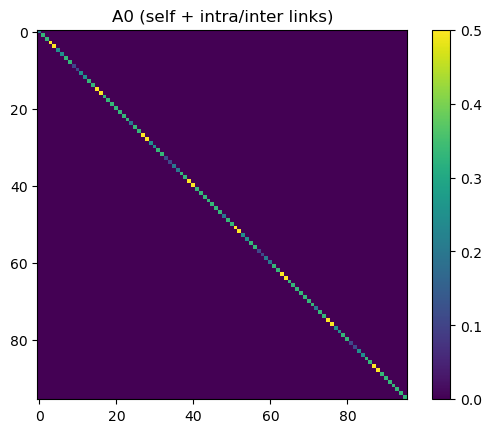

In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from src.dataset import create as create_dataset

feeders, data_shape, num_class, A, parts = create_dataset(
    "playground",
    graph="playground-4",
    labeling="intra-inter",
    max_hop=1,
    inter_link="pairwise",
    base=[11,12],
    hop=1,
    dilation=1,
    part="body",
    root_folder="/Users/alexeidelgado/Desktop/mpgcn-playground-scenes/workdir",
    object_folder="/Users/alexeidelgado/Desktop/mpgcn-playground-scenes/workdir",
    train_batch_size=1,
    eval_batch_size=1,
    num_frame=48,
    inputs="JVBM",
    person_id=[0,1,2,3],
    debug=False,
)

print("Adjacency matrix shape:", A.shape)
plt.imshow(A[0], cmap='viridis')
plt.title("A0 (self + intra/inter links)")
plt.colorbar()
plt.show()

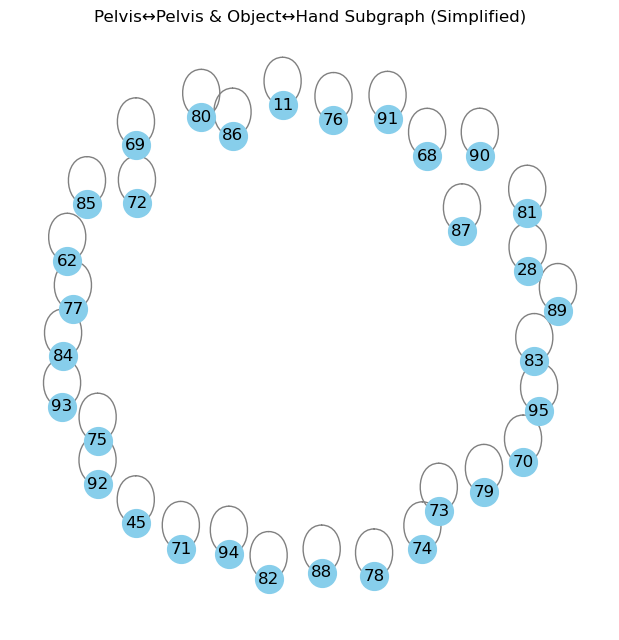

In [6]:
import networkx as nx

# Convert adjacency matrix to graph
A0 = A[0]
G = nx.from_numpy_array(A0)

# Pelvis joint indices per person (assuming COCO layout)
pelvis_indices = [11, 28, 45, 62]  # 11 + 17*i for i in [0..3]
object_indices = list(range(68, 96))

# Draw a subgraph of people + pelvis links
subset_nodes = pelvis_indices + object_indices
subG = G.subgraph(subset_nodes)

plt.figure(figsize=(6, 6))
pos = nx.spring_layout(subG, seed=42)
nx.draw(subG, pos, with_labels=True, node_size=400, node_color='skyblue', edge_color='gray')
plt.title("Pelvis↔Pelvis & Object↔Hand Subgraph (Simplified)")
plt.show()

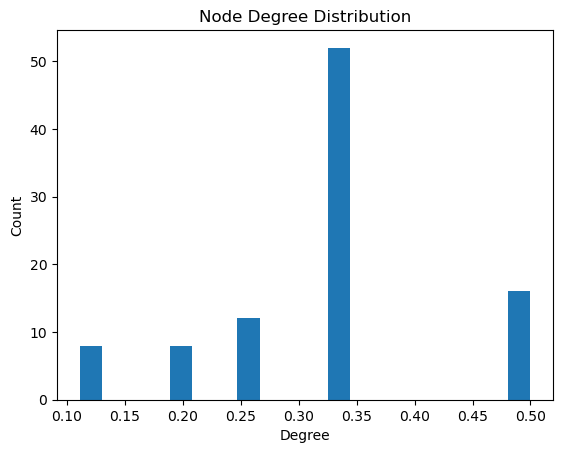

In [7]:
degrees = np.sum(A[0], axis=1)
plt.hist(degrees, bins=20)
plt.title("Node Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Count")
plt.show()

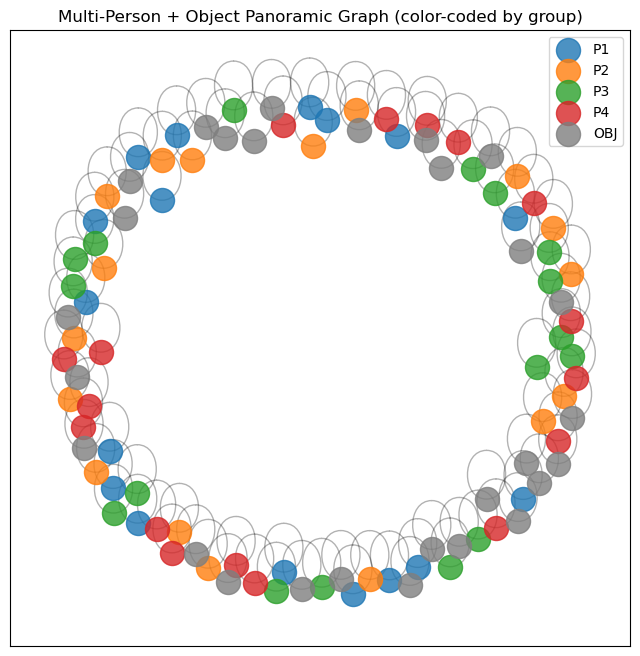

In [8]:
import networkx as nx
import matplotlib.pyplot as plt

A0 = A[0]
G = nx.from_numpy_array(A0)

# Define person node ranges
person_ranges = {
    "P1": range(0,17),
    "P2": range(17,34),
    "P3": range(34,51),
    "P4": range(51,68),
    "OBJ": range(68,96)
}
colors = {"P1":"#1f77b4", "P2":"#ff7f0e", "P3":"#2ca02c", "P4":"#d62728", "OBJ":"#7f7f7f"}

plt.figure(figsize=(8,8))
pos = nx.spring_layout(G, seed=42)
for label, nodes in person_ranges.items():
    nx.draw_networkx_nodes(G, pos, nodelist=list(nodes), node_color=colors[label], label=label, alpha=0.8)
nx.draw_networkx_edges(G, pos, alpha=0.3)
plt.legend()
plt.title("Multi-Person + Object Panoramic Graph (color-coded by group)")
plt.show()


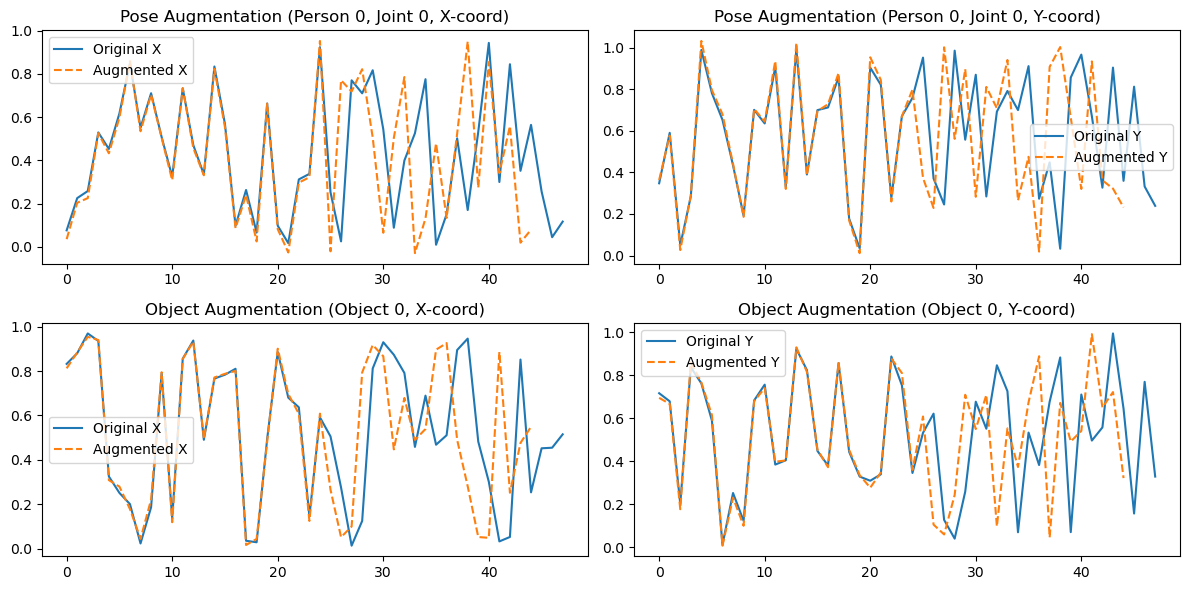

Augmentation types applied:
- Temporal jitter
- Random crop (if sequence > T_target)
- Random drop (5% probability per frame)
- Speed scaling (0.8-1.2x, 30% probability)
- Joint jitter (small Gaussian noise)
- Joint translation (random shift)
- Joint scaling (0.95-1.05x)
- Object jitter (small Gaussian noise)


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from src.dataset.augment import SkeletonAugmenter

# sample data (similar to what would be in the dataset)
T, M, V, C = 48, 4, 17, 3
T_obj, O, C_obj = 48, 10, 3  # Time, Objects, Channels

# Create random pose and object data
pose = np.random.rand(T, M, V, C)
obj = np.random.rand(T_obj, O, C_obj)

# Create augmenter and apply
augmenter = SkeletonAugmenter(enable=True)
pose_aug, obj_aug = augmenter(pose.copy(), obj.copy(), T_target=T)

plt.figure(figsize=(12, 6))

# Plot original vs augmented pose data (using first person, first joint)
plt.subplot(2, 2, 1)
plt.plot(pose[:, 0, 0, 0], label='Original X')
plt.plot(pose_aug[:, 0, 0, 0], label='Augmented X', linestyle='--')
plt.title('Pose Augmentation (Person 0, Joint 0, X-coord)')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(pose[:, 0, 0, 1], label='Original Y')
plt.plot(pose_aug[:, 0, 0, 1], label='Augmented Y', linestyle='--')
plt.title('Pose Augmentation (Person 0, Joint 0, Y-coord)')
plt.legend()

# Plot original vs augmented object data (using first object)
plt.subplot(2, 2, 3)
plt.plot(obj[:, 0, 0], label='Original X')
plt.plot(obj_aug[:, 0, 0], label='Augmented X', linestyle='--')
plt.title('Object Augmentation (Object 0, X-coord)')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(obj[:, 0, 1], label='Original Y')
plt.plot(obj_aug[:, 0, 1], label='Augmented Y', linestyle='--')
plt.title('Object Augmentation (Object 0, Y-coord)')
plt.legend()

plt.tight_layout()
plt.show()

In [6]:
import torch
x = torch.tensor(sample).unsqueeze(0).float().to("cpu")  # (1, 4, 6, 48, 96, 1) => MP-GCN internally rearranges

out = model(x)
print(out)

(tensor([[ 0.0073, -0.0220, -0.0490, -0.0502,  0.0154, -0.0069,  0.0371]],
       grad_fn=<AddmmBackward0>), tensor([[[[[ 0.7792],
           [ 1.0304],
           [ 1.5365],
           ...,
           [ 4.0295],
           [ 3.3045],
           [ 0.0000]],

          [[ 0.7488],
           [ 0.0000],
           [ 0.0000],
           ...,
           [ 3.0465],
           [ 6.4006],
           [ 7.1824]],

          [[ 0.0000],
           [ 0.0000],
           [ 1.1661],
           ...,
           [ 3.7617],
           [ 0.1669],
           [ 0.0000]],

          ...,

          [[ 0.0000],
           [ 1.0457],
           [ 0.0000],
           ...,
           [ 0.4580],
           [ 0.2200],
           [ 0.9749]],

          [[ 0.0000],
           [ 0.0000],
           [ 0.0000],
           ...,
           [ 0.0000],
           [ 0.8995],
           [ 0.0000]],

          [[ 1.0304],
           [ 0.5900],
           [ 1.1408],
           ...,
           [ 0.2381],
           [ 0.1148],

In [7]:
with torch.no_grad():
    logits, features = model(x)

print("logits shape:", logits.shape)      # should be torch.Size([1, 6])
print("features shape:", features.shape)  # some big 5D or 6D tensor

logits shape: torch.Size([1, 7])
features shape: torch.Size([1, 256, 12, 96, 1])
